In [1]:
import numpy as np
import os 
from sklearn.model_selection import train_test_split

if 'src' in os.getcwd():
    os.chdir('..')
    
from statrob import StatrobGlobal, MLPClassifier
from create_data_examples import Dataset, DatasetPreprocessor
from explainers import GrowingSpheresExplainer
from plot_helpers import plot_crisp_decision_boundary, plot_decision_boundary_with_artifacts
from experiments_helpers import SameSampleExperimentData


dataset = Dataset('moons')
# dataset_preprocessor = DatasetPreprocessor(dataset, one_hot=True)


e1 = SameSampleExperimentData(
        dataset, 
        random_state=324,
        one_hot_encode=True,
        standardize='minmax'
    )

sample1, sample2 = e1.create()
X_train, X_test, y_train, y_test = sample1
X_train2, X_test2, y_train2, y_test2 = sample2

dataset_preprocessor = e1.preprocessor


blackbox = MLPClassifier(X_test.shape[1], seed=122, hidden_dims=[128, 128, 128])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
blackbox.fit(X_train, y_train, X_val, y_val)
acc, rec, prc, f1 = blackbox.evaluate(X_test, y_test)
print(f'Accuracy: {acc}, Recall: {rec}, Precision: {prc}, F1: {f1}')

blackbox2 = MLPClassifier(X_train2.shape[1], seed=123)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)
blackbox2.fit(X_train2, y_train2, X_val2, y_val2)
acc2, rec2, prc2, f12 = blackbox2.evaluate(X_test, y_test)
print(f'Accuracy: {acc2}, Recall: {rec2}, Precision: {prc2}, F1: {f12}')

2024-03-04 19:19:52.334778: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 19:19:52.371190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/ignacy/research/robust-cf
Epoch: 0, Loss: 0.6464340686798096
Epoch: 0, Validation Loss: 0.6490941643714905
Epoch: 5, Validation Loss: 0.3449117839336395
Epoch: 10, Loss: 0.24832506477832794
Epoch: 10, Validation Loss: 0.31274494528770447
Epoch: 15, Validation Loss: 0.282003790140152
Epoch: 20, Loss: 0.19232085347175598
Epoch: 20, Validation Loss: 0.24077893793582916
Epoch: 25, Validation Loss: 0.1920175403356552
Epoch: 30, Loss: 0.1490451544523239
Epoch: 30, Validation Loss: 0.14557816088199615
Epoch: 35, Validation Loss: 0.1086110919713974
Epoch: 40, Loss: 0.11557018756866455
Epoch: 40, Validation Loss: 0.08101923018693924
Epoch: 45, Validation Loss: 0.06591326743364334
Epoch: 50, Loss: 0.08050422370433807
Epoch: 50, Validation Loss: 0.05146387219429016
Epoch: 55, Validation Loss: 0.040695976465940475
Epoch: 60, Loss: 0.05029631778597832
Epoch: 60, Validation Loss: 0.0342959463596344
Epoch: 65, Validation Loss: 0.02795994095504284
Epoch: 70, Loss: 0.02898302488029003
Epoch: 70, 

In [2]:
X_train_np = X_train.to_numpy()
y_train_np = y_train
X_test_np = X_test.to_numpy()
y_test_np = y_test


blackbox_predic_crisp_fn = lambda x: blackbox.predict_crisp(x).detach().numpy()
blackbox_predic_proba_fn = lambda x: blackbox.predict_proba(x).detach().numpy()
blackbox2_predic_crisp_fn = lambda x: blackbox2.predict_crisp(x).detach().numpy()
blackbox2_predic_proba_fn = lambda x: blackbox2.predict_proba(x).detach().numpy()

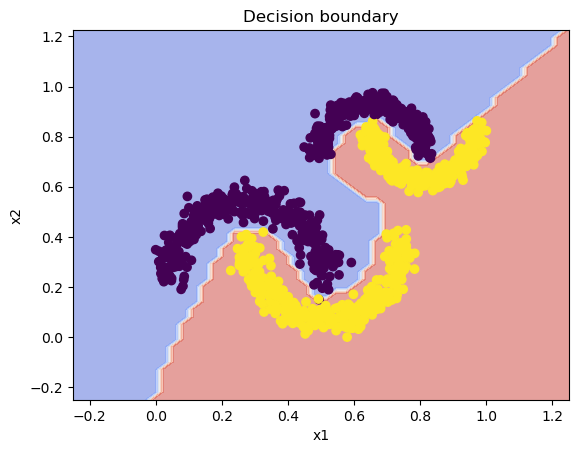

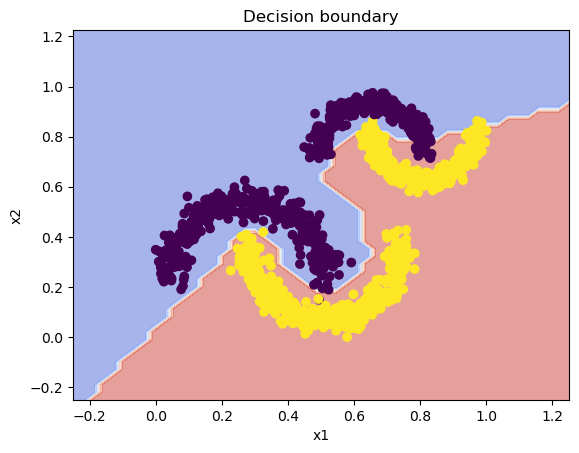

In [3]:

plot_crisp_decision_boundary(blackbox_predic_crisp_fn, X_train_np, y_train_np)
plot_crisp_decision_boundary(blackbox2_predic_crisp_fn, X_train_np, y_train_np)

In [4]:
gs_explainer = GrowingSpheresExplainer(
                    keys_mutable=dataset_preprocessor.X_train.columns.tolist(),
                    keys_immutable=[],
                    feature_order=dataset_preprocessor.X_train.columns.tolist(),
                    binary_cols=dataset_preprocessor.encoder.get_feature_names_out().tolist(),
                    continous_cols=dataset_preprocessor.continuous_columns,
                    pred_fn_crisp=blackbox_predic_crisp_fn,
                    target_proba=0.5,
                )    
gs_explainer.prep()

In [5]:
statrob_explainer = StatrobGlobal(
    dataset=dataset,
    preprocessor=dataset_preprocessor,
    blackbox=blackbox
)

statrob_explainer.fit(k_mlps=24)

Training the ensemble of models
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Training the ensemble of models done


In [6]:
from robx import robx_algorithm



<div style="background-color: #880000; color: #FFFFFF; font-weight: bold; padding: 10px; margin: 10px 0 20px 0; text-align: center; border-radius: 10px;">Generation</div>

In [23]:
idx = 1
original_example = X_test[idx:idx+1]
original_example_np = original_example.to_numpy().reshape(-1)
original_class = blackbox_predic_crisp_fn(original_example)
cf = gs_explainer.generate(original_example)
cf_class = blackbox_predic_crisp_fn(cf)


print(f'Original example class: {original_class}. Example: {original_example_np}')
print(f'Counterfactual class: {cf_class}. Counterfactual: {cf}')

Original example class: [1]. Example: [0.94884847 0.73904368]
Counterfactual class: [0]. Counterfactual: [0.89132089 0.78049637]


In [24]:
statrob_cf = statrob_explainer.optimize(cf.reshape(1, -1), target_class=cf_class, estimation_method='MLE')

statrob_cf_class = blackbox_predic_crisp_fn(statrob_cf)
print(f'Statrob Counterfactual class: {statrob_cf_class}. Counterfactual: {statrob_cf}')

Counterfactual does not pass the test!: 
Counterfactual [0.8731587  0.79094528] 
Predictions: [0.72094285 0.72151554 0.7469386  0.9955895  0.48072475 0.7796538
 0.92802745 0.95684767 0.92802745 0.9955895  0.72151554 0.89140713
 0.72094285 0.881878   0.881878   0.881878   0.94913405 0.76861155
 0.7469386  0.92802745 0.95684767 0.76861155 0.95684767 0.48072475]
Statrob Counterfactual class: [0]. Counterfactual: [0.8731587  0.79094528]


In [25]:
robx_cf, _ = robx_algorithm(
    X_train = X_train.to_numpy(),
    predict_class_proba_fn = blackbox_predic_proba_fn,
    start_counterfactual = cf,
)

robx_cf_class = blackbox_predic_crisp_fn(robx_cf)
print(f'Robust Counterfactual class: {robx_cf_class}. Counterfactual: {robx_cf}')


Robust Counterfactual class: [0]. Counterfactual: [0.49167725 0.76794023]


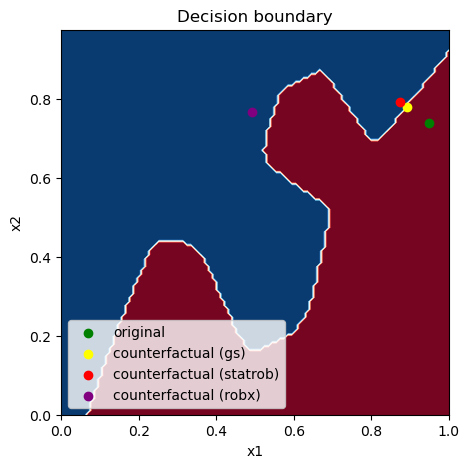

In [27]:
plot_decision_boundary_with_artifacts(
    blackbox_predic_crisp_fn, 
    X_train_np, 
    y_train_np,
    artifacts=[
        {'coords': original_example_np.reshape(-1), 'color': 'green', 'marker': 'o', 'label': 'original'},
        {'coords': cf.reshape(-1), 'color': 'yellow', 'marker': 'o', 'label': 'counterfactual (gs)'},
        {'coords': statrob_cf.reshape(-1), 'color': 'red', 'marker': 'o', 'label': 'counterfactual (statrob)'},
        {'coords': robx_cf.reshape(-1), 'color': 'purple', 'marker': 'o', 'label': 'counterfactual (robx)'},
    ]
)

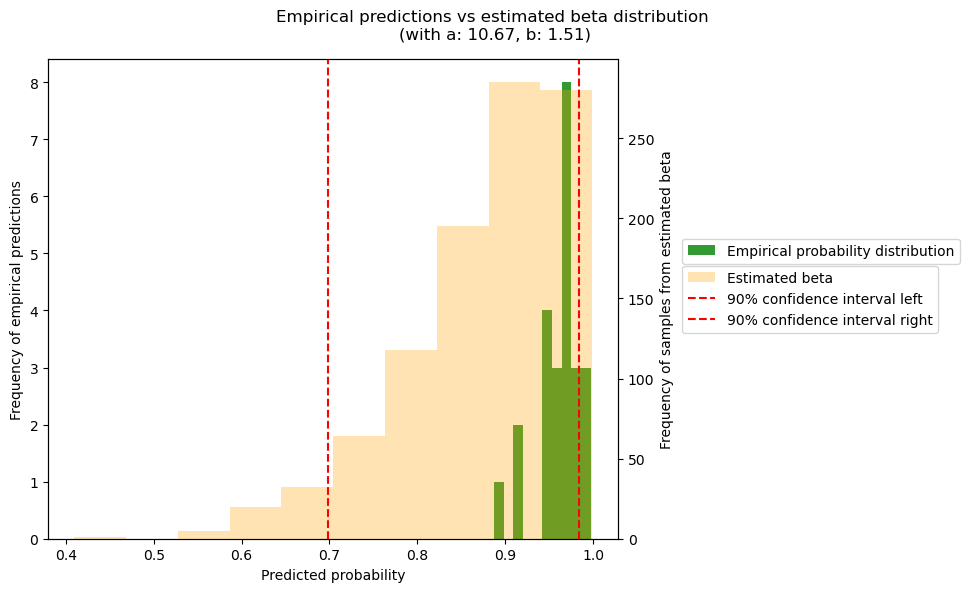

In [ ]:
from statrob import plot_beta_on_original, estimate_beta_distribution, ensemble_predict_proba, plot_beta, plot_distribution_of_predictions
import matplotlib.pyplot as plt
import scipy.stats

probs = ensemble_predict_proba(statrob_explainer.models, statrob_cf)
probs = probs if statrob_cf_class == 1 else 1 - probs
alpha, beta = estimate_beta_distribution(probs.reshape(-1), method='MLE')
# plot_distribution_of_predictions(probs)
# plot_beta(alpha, beta)

condifence = 0.9

left, right = scipy.stats.beta.interval(condifence, alpha, beta)


fig, ax = plt.subplots(figsize=(10,6))
samples = np.random.beta(alpha, beta, size=1000)

ax.hist(probs, bins=10, density=False, alpha=0.8, color='green', label='Empirical probability distribution')
ax2 = ax.twinx()
ax2.hist(samples, bins=10, density=False, alpha=0.3, color='orange', label='Estimated beta')

# Draw the 90% confidence interval
plt.axvline(left, color='red', linestyle='--', label='90% confidence interval left')
plt.axvline(right, color='red', linestyle='--', label='90% confidence interval right')

# Place legend outside the main plot box
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.6))


plt.suptitle(f'Empirical predictions vs estimated beta distribution \n(with a: {alpha:.2f}, b: {beta:.2f})')

ax.set_xlabel('Predicted probability')
ax.set_ylabel('Frequency of empirical predictions')
ax2.set_ylabel('Frequency of samples from estimated beta')


plt.tight_layout()

plt.show()